<a href="https://colab.research.google.com/github/erlancassiano/burned-area-detection/blob/master/pre_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Theory

This project uses Landsat images. There are several reflectance bands available to use, besides a combination of them can be more sensitive to some phenomena like vegetation or water.

### Normalized Burn Ratio (NBR)

The Normalized Burn Ratio (NBR) is an index that highlights burnt areas in large fire zones. The formula combines the near-infrared (NIR) and shortwave infrared (SWIR) wavelengths.

Healthy vegetation shows a very high reflectance in the NIR, and low reflectance in the SWIR portion of the spectrum, (see figure below). The contrary happens for areas destroyed by fire; recently burnt areas show a low reflectance in the NIR and high reflectance in the SWIR. Therefore,  the normalized difference between the NIR and the SWIR is a good discriminant for this kind of phenomenon.



![fig](https://github.com/erlancassiano/burned-area-detection/blob/master/img/Spectral_responses.jpg?raw=1)

### Burn Severity
The difference between the pre-fire and post-fire NBR obtained from the images is used to calculate the delta NBR. A higher value of dNBR indicates more severe damage, while areas with negative dNBR values may indicate regrowth following a fire.

#Instal and import packages

In [ ]:
!pip install xarray
!pip install earthpy
!pip install rioxarray

In [30]:
import os
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib import colors
import seaborn as sns
import numpy as np

from shapely.geometry import mapping, box
from rasterio.plot import plotting_extent

# Prettier plotting with seaborn
sns.set_style('white')
sns.set(font_scale=1.5)



We can download the satellite images of five bands (R G B NIR SWIR ) and the  one band NBR images (NBR= (NIR- SWIR)/(NIR + SWIR) ) from the bucket availables and we will use Googlle Drive to store all the files

**Mounting Google Drive**

In [6]:
from google.colab import drive
drive.mount('/content/drive') # accept the acesss pop-up

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
folder_path = '/content/drive/MyDrive/Fox17/burned_area_detector' # local where all files will be downloaded and updated

#### **Bariloche** 

File used to train the ML

In [ ]:
!mkdir -p $folder_path/data/img/5D/2021-03-07_2021-03-29/
!wget https://storage.googleapis.com/dym-datasets-public/fires-bariloche/5D/2021-03-07_2021-03-29/0000000000-0000000000.tif -O $folder_path/data/img/5D/2021-03-07_2021-03-29/0000000000-0000000000.tif

In [9]:
# Create the path to your data
landsat_train_fire_path = os.path.join(folder_path+'/data/img/5D/2021-03-07_2021-03-29/') ## folder with the data to predict(upload your data to this folder)
landsat_train_fire_path

'/content/drive/MyDrive/Fox17/burned_area_detector/data/img/5D/2021-03-07_2021-03-29/'

In [10]:
train_fire_paths = glob(os.path.join(landsat_train_fire_path,
                                        "*-*.tif")) ## update de string with order the bands and extension file, .TIF different from .tif
train_fire_paths

['/content/drive/MyDrive/Fox17/burned_area_detector/data/img/5D/2021-03-07_2021-03-29/0000000000-0000000000.tif']

Sort the data to ensure bands are in the correct order

In [11]:
train_fire_paths.sort()
train_fire_path=train_fire_paths[0]
train_fire_path

'/content/drive/MyDrive/Fox17/burned_area_detector/data/img/5D/2021-03-07_2021-03-29/0000000000-0000000000.tif'

In [12]:
# Turning the file of bands into a single xarray object   
train_fire_path_xr = rxr.open_rasterio(train_fire_path)
train_fire_path_xr

<xarray.DataArray (band: 5, y: 14848, x: 12058)>
[895185920 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5
  * x            (x) float64 -72.2 -72.2 -72.2 -72.2 ... -71.12 -71.12 -71.12
  * y            (y) float64 -41.49 -41.49 -41.49 ... -42.83 -42.83 -42.83
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B4_median', 'B3_median', 'B2_median', 'B8_median', 'B11_...

AttributeError: ignored

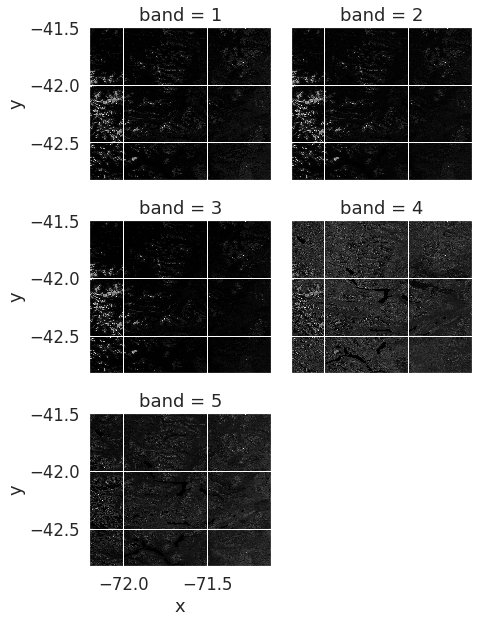

In [16]:
train_fire_path_xr.plot.imshow(col="band",
                                 col_wrap=2,
                                 cmap="Greys_r")
plt.show()

Below is a function called open_clean_bands that opens a single tif file and returns an xarray object. In the following lessons you will build this function out to process and clean your Landsat data.

In [48]:
!mkdir -p $folder_path/TRAIN/

In [49]:
!gdal_calc.py \
-A $train_fire_path \
--A_band=4 \
-B $train_fire_path \
--B_band=5 \
--calc="(A-B)/(A+B)" \
--outfile=$folder_path/TRAIN/NBR_2021-03-07_2021-03-29_0.tif

0 .. 10 .. 20 .. 30 .. 40 .. 50 .. 60 .. 70 .. 80 .. 90 .. 100 - Done


In [5]:
# Turning the file of bands into a single xarray object   
landsat_train_fire_xr = rxr.open_rasterio(folder_path +'/TRAIN/NBR_2021-03-07_2021-03-29_0.tif')
landsat_train_fire_xr

<xarray.DataArray (band: 1, y: 14848, x: 12058)>
[179037184 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -72.2 -72.2 -72.2 -72.2 ... -71.12 -71.12 -71.12
  * y            (y) float64 -41.49 -41.49 -41.49 ... -42.83 -42.83 -42.83
    spatial_ref  int64 0
Attributes:
    _FillValue:    3.4028234663852886e+38
    scale_factor:  1.0
    add_offset:    0.0

In [1]:
# we need more ram to use it

# landsat_train_fire_xr.plot.imshow(col="band", 
#                                  col_wrap=1,
#                                  cmap="Greys_r")
# plt.show()

#### **Image to predict**

File used to predict with the ML

In [6]:
# Create the path to your data
landsat_post_fire_path = os.path.join(folder_path+'/POSTFIRE') ## folder with the data to predict(upload your data to this folder)
landsat_post_fire_path

'/content/drive/MyDrive/Fox17/burned_area_detector/POSTFIRE'

Generate a list of tif files

In [7]:
post_fire_paths = glob(os.path.join(landsat_post_fire_path,
                                        "*_B*.TIF")) ## update de string with order the bands
post_fire_paths

['/content/drive/MyDrive/Fox17/burned_area_detector/POSTFIRE/LC08_L1TP_225068_20220819_20220824_02_T1_B6_recortado.TIF',
 '/content/drive/MyDrive/Fox17/burned_area_detector/POSTFIRE/LC08_L1TP_225068_20220819_20220824_02_T1_B5_recortado.TIF',
 '/content/drive/MyDrive/Fox17/burned_area_detector/POSTFIRE/LC08_L1TP_225068_20220819_20220824_02_T1_B4_recortado.TIF',
 '/content/drive/MyDrive/Fox17/burned_area_detector/POSTFIRE/LC08_L1TP_225068_20220819_20220824_02_T1_B3_recortado.TIF',
 '/content/drive/MyDrive/Fox17/burned_area_detector/POSTFIRE/LC08_L1TP_225068_20220819_20220824_02_T1_B2_recortado.TIF']

Sort the data to ensure bands are in the correct order

In [8]:
post_fire_paths.sort()
post_fire_paths

['/content/drive/MyDrive/Fox17/burned_area_detector/POSTFIRE/LC08_L1TP_225068_20220819_20220824_02_T1_B2_recortado.TIF',
 '/content/drive/MyDrive/Fox17/burned_area_detector/POSTFIRE/LC08_L1TP_225068_20220819_20220824_02_T1_B3_recortado.TIF',
 '/content/drive/MyDrive/Fox17/burned_area_detector/POSTFIRE/LC08_L1TP_225068_20220819_20220824_02_T1_B4_recortado.TIF',
 '/content/drive/MyDrive/Fox17/burned_area_detector/POSTFIRE/LC08_L1TP_225068_20220819_20220824_02_T1_B5_recortado.TIF',
 '/content/drive/MyDrive/Fox17/burned_area_detector/POSTFIRE/LC08_L1TP_225068_20220819_20220824_02_T1_B6_recortado.TIF']

Below is a function called open_clean_bands that opens a single tif file and returns an xarray object. In the following lessons you will build this function out to process and clean your Landsat data.

In [9]:
def open_clean_bands(band_path):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.
        
    Returns
    -------
    An single xarray object with the Landsat band data.

    """
     
    return rxr.open_rasterio(band_path, masked=True).squeeze()

The code below takes each band and stacks it into a new single output array.

 **NOTE:** this approach is only efficient if you wish to process ALL of the bands in your data. Given the size of Landsat data, you likely will want to remove bands that you don’t need and if your study area is smaller than the entire image, you may also want to clip your data.

In [10]:
# Open all bands in a loop
all_bands = []
for i, aband in enumerate(post_fire_paths):
    all_bands.append(open_clean_bands(aband))
    # Assign a band number to the new xarray object
    all_bands[i]["band"]=i+1
all_bands

[<xarray.DataArray (y: 1478, x: 2243)>
 [3315154 values with dtype=float32]
 Coordinates:
     band         int64 1
   * x            (x) float64 1.648e+05 1.648e+05 ... 2.32e+05 2.320e+05
   * y            (y) float64 -1.237e+06 -1.237e+06 ... -1.281e+06 -1.281e+06
     spatial_ref  int64 0
 Attributes:
     scale_factor:  1.0
     add_offset:    0.0, <xarray.DataArray (y: 1478, x: 2243)>
 [3315154 values with dtype=float32]
 Coordinates:
     band         int64 2
   * x            (x) float64 1.648e+05 1.648e+05 ... 2.32e+05 2.320e+05
   * y            (y) float64 -1.237e+06 -1.237e+06 ... -1.281e+06 -1.281e+06
     spatial_ref  int64 0
 Attributes:
     scale_factor:  1.0
     add_offset:    0.0, <xarray.DataArray (y: 1478, x: 2243)>
 [3315154 values with dtype=float32]
 Coordinates:
     band         int64 3
   * x            (x) float64 1.648e+05 1.648e+05 ... 2.32e+05 2.320e+05
   * y            (y) float64 -1.237e+06 -1.237e+06 ... -1.281e+06 -1.281e+06
     spatial_ref  int64 0

In [11]:
# Turning the list of bands into a single xarray object    
landsat_post_fire_xr = xr.concat(all_bands, dim="band") 
landsat_post_fire_xr

<xarray.DataArray (band: 5, y: 1478, x: 2243)>
array([[[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan, ...,  9437.,  9449.,  9506.],
        [   nan,    nan,    nan, ...,  9450.,  9421.,  9482.],
        [   nan,    nan,    nan, ...,  9417.,  9418.,  9455.]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan, ...,  8557.,  8580.,  8612.],
        [   nan,    nan,    nan, ...,  8575.,  8569.,  8578.],
        [   nan,    nan,    nan, ...,  8551.,  8548.,  8646.]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan, ...,  7592.,  7657.,  7800.],
        [   nan,    nan,    nan, ...,  7628.,  7597.,  7685.],
        [   nan,    nan,    nan, ...,  7595.,  7579.,  7642.]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan, ..., 16683., 17050., 15490.],
        [   nan,    nan,    nan, ..., 16597., 17242., 16001.],
        [   nan,    nan,    nan, ..., 16651., 16753., 17239.]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan, ..., 10416., 10693., 10908.],
        [   nan,    nan,    nan, ..., 10461., 10575., 10754.],
        [   nan,    nan,    nan, ..., 10446., 10390., 10855.]]],
      dtype=float32)
Coordinates:
  * band         (band) int64 1 2 3 4 5
  * x            (x) float64 1.648e+05 1.648e+05 ... 2.32e+05 2.320e+05
  * y            (y) float64 -1.237e+06 -1.237e+06 ... -1.281e+06 -1.281e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

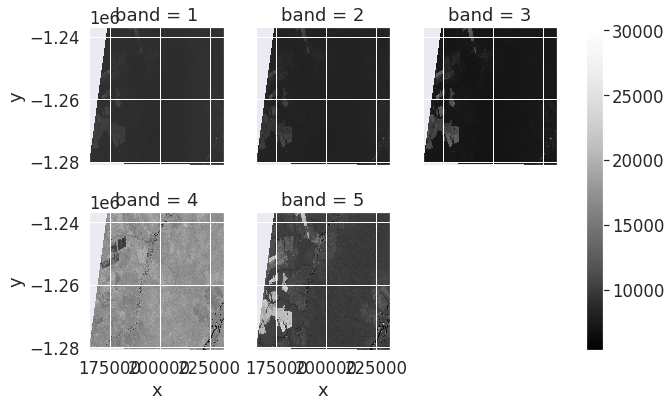

In [12]:
landsat_post_fire_xr.plot.imshow(col="band",
                                 col_wrap=3,
                                 cmap="Greys_r")
plt.show()

##### Plot RGB image

Plotting 3 band color composite images for Landsat using the earthpy ep.plot_rgb() function. Refer to the landsat bands in the table at the top of this page to figure out the red, green and blue bands. Or read the ESRI landsat 8 band combinations post.

ep.plot_rgb() requires:

the numpy array containing the bands that you wish to plot. You can access this by using xarray_name.values IMPORTANT: this array should be in xarray band order (bands first).

The numeric location of bands that you wish to plot in the array.

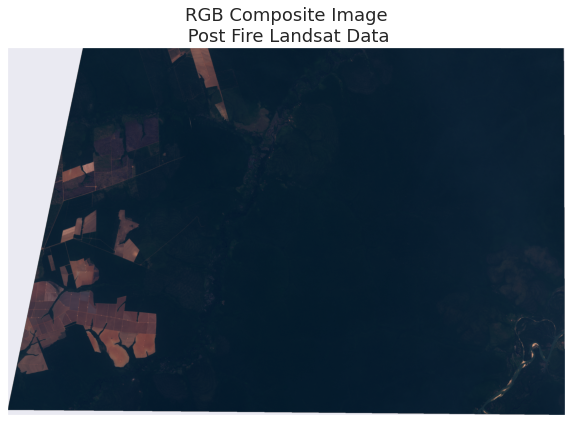

In [13]:
ep.plot_rgb(landsat_post_fire_xr.values,
            rgb=[2,1,0], ## change the elemnts according the bands in your data
            title="RGB Composite Image\n Post Fire Landsat Data")
plt.show()

The image above looks dark. We can stretch the image as you did with the NAIP data, too. Below we use the stretch argument built into the earthpy plot_rgb() function. The str_clip argument allows  to specify how much of the tails of the data that we want to clip off. The larger the number, the most the data will be stretched or brightened.

When the range of pixel brightness values is closer to 255, a lighter image is rendered by default. We can stretch the values to extend to the full 0-255 range of potential values to increase the visual contrast of the image.

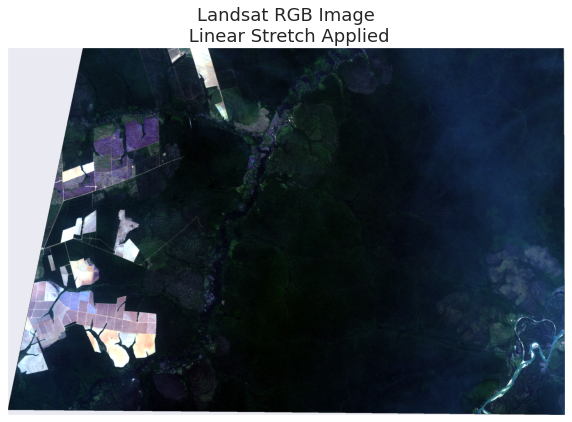

In [14]:
ep.plot_rgb(landsat_post_fire_xr.values,
            rgb=[2,1,0], ## change the elemnts according the bands in your data
            title="Landsat RGB Image\n Linear Stretch Applied",
            stretch=True,
            str_clip=1)
plt.show()

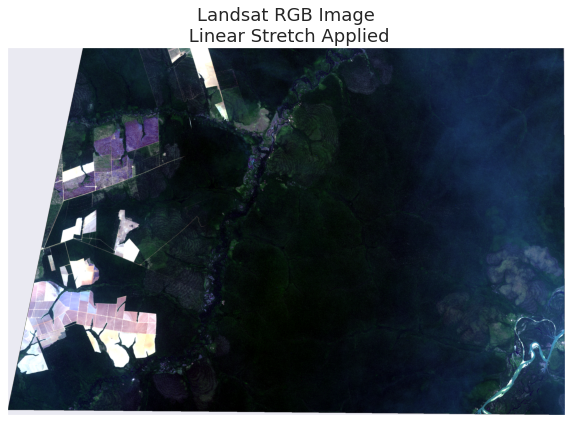

In [15]:
# Adjust the amount of linear stretch to futher brighten the image
ep.plot_rgb(landsat_post_fire_xr.values,
            rgb=[2,1,0],
            title="Landsat RGB Image\n Linear Stretch Applied",
            stretch=True,
            str_clip=2)
plt.show()

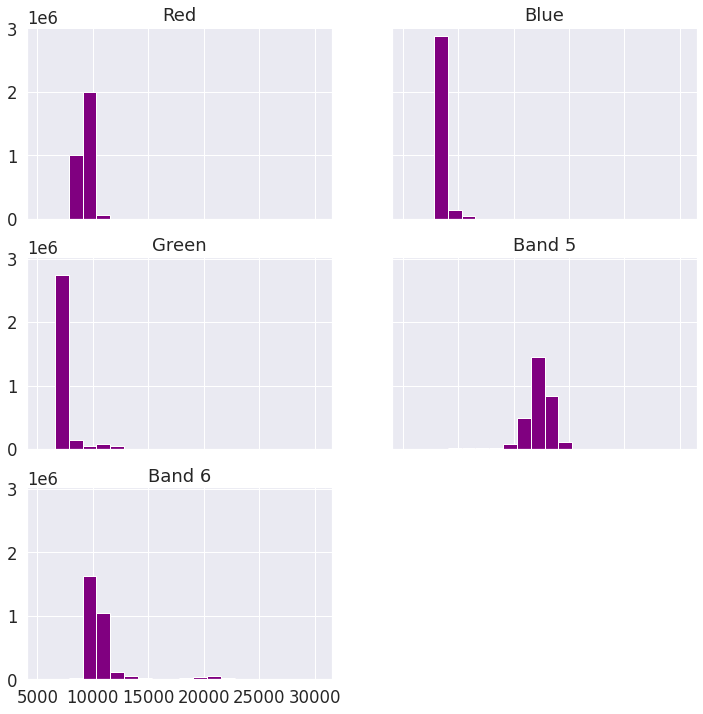

In [16]:
# Plot all band histograms using earthpy
band_titles = [           
               "Red",
               "Blue", 
               "Green", 
               "Band 5", 
               "Band 6"] ## change the elemnts according the bands in your data

ep.hist(landsat_post_fire_xr.values,
        title=band_titles)

plt.show()

##### Computing  NBR index 

In [18]:
def combine_tifs(tif_list):
    """A function that combines a list of tifs in the same CRS
    and of the same extent into an xarray object

    Parameters
    ----------
    tif_list : list
        A list of paths to the tif files that you wish to combine.

    Returns
    -------
    An xarray object with all of the tif files in the listmerged into 
    a single object.

    """

    out_xr = []
    for i, tif_path in enumerate(tif_list):
        out_xr.append(rxr.open_rasterio(tif_path, masked=True).squeeze())
        out_xr[i]["band"] = i+1

    return xr.concat(out_xr, dim="band")

In [19]:
# Import and stack post fire Landsat data - notice you are only stacking bands 5-7

post_fire_paths.sort()

landsat_post_fire = combine_tifs(post_fire_paths)

extent_landsat = plotting_extent(
    landsat_post_fire[0].values, landsat_post_fire.rio.transform())

landsat_post_fire

<xarray.DataArray (band: 5, y: 1478, x: 2243)>
array([[[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan, ...,  9437.,  9449.,  9506.],
        [   nan,    nan,    nan, ...,  9450.,  9421.,  9482.],
        [   nan,    nan,    nan, ...,  9417.,  9418.,  9455.]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan, ...,  8557.,  8580.,  8612.],
        [   nan,    nan,    nan, ...,  8575.,  8569.,  8578.],
        [   nan,    nan,    nan, ...,  8551.,  8548.,  8646.]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan, ...,  7592.,  7657.,  7800.],
        [   nan,    nan,    nan, ...,  7628.,  7597.,  7685.],
        [   nan,    nan,    nan, ...,  7595.,  7579.,  7642.]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan, ..., 16683., 17050., 15490.],
        [   nan,    nan,    nan, ..., 16597., 17242., 16001.],
        [   nan,    nan,    nan, ..., 16651., 16753., 17239.]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [   nan,    nan,    nan, ..., 10416., 10693., 10908.],
        [   nan,    nan,    nan, ..., 10461., 10575., 10754.],
        [   nan,    nan,    nan, ..., 10446., 10390., 10855.]]],
      dtype=float32)
Coordinates:
  * band         (band) int64 1 2 3 4 5
  * x            (x) float64 1.648e+05 1.648e+05 ... 2.32e+05 2.320e+05
  * y            (y) float64 -1.237e+06 -1.237e+06 ... -1.281e+06 -1.281e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

Next, you can calculate NBR on the post fire data. Remember that NBR uses different bands than NDVI but the calculation formula is the same. For landsat 8 data you will be using bands 7 and 5. And remember because python starts counting at 0 (0-based indexing), and we got just bands 5, 6, 7 in our xarray, that will be indices 2 and 0 when you access them in your numpy array.

Below raster math is used to calculate normalized difference.

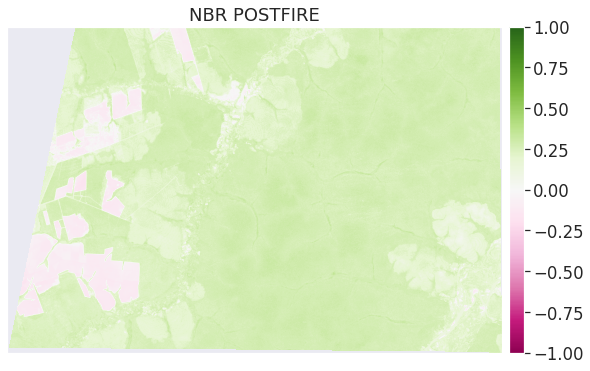

In [20]:
# Calculate NBR & plot POSTFIRE
landsat_postfire_nbr = (
    landsat_post_fire[3]-landsat_post_fire[4]) / (landsat_post_fire[3]+landsat_post_fire[4])

fig, ax = plt.subplots(figsize=(12, 6))

ep.plot_bands(landsat_postfire_nbr,
              cmap='PiYG',
              vmin=-1,
              vmax=1,
              ax=ax,
              extent=extent_landsat,
              title="NBR POSTFIRE")

plt.show()

# POST VISUAL CHECK

Next, calculate NBR for the pre-fire data for a sannity check.


### PREFIRE

In [21]:
# Create the path to your data
all_landsat_pre_bands_path = os.path.join(folder_path+'/PREFIRE')
all_landsat_pre_bands_path

'/content/drive/MyDrive/Fox17/burned_area_detector/PREFIRE'

In [22]:
# Generate a list of tif files
pre_fire_paths = glob(os.path.join(all_landsat_pre_bands_path,
                                        "*_B*.tif"))
pre_fire_paths

['/content/drive/MyDrive/Fox17/burned_area_detector/PREFIRE/LC08_L1TP_225068_20220531_20220609_02_T1_B6_recorto.tif',
 '/content/drive/MyDrive/Fox17/burned_area_detector/PREFIRE/LC08_L1TP_225068_20220531_20220609_02_T1_B5_recorto.tif',
 '/content/drive/MyDrive/Fox17/burned_area_detector/PREFIRE/LC08_L1TP_225068_20220531_20220609_02_T1_B4_recorto.tif',
 '/content/drive/MyDrive/Fox17/burned_area_detector/PREFIRE/LC08_L1TP_225068_20220531_20220609_02_T1_B3_recorto.tif',
 '/content/drive/MyDrive/Fox17/burned_area_detector/PREFIRE/LC08_L1TP_225068_20220531_20220609_02_T1_B2_recorto.tif']

In [23]:
# Import and stack post fire Landsat data - notice you are only stacking bands 5-7

pre_fire_paths.sort()

landsat_pre_fire = combine_tifs(pre_fire_paths)

extent_landsat = plotting_extent(
    landsat_post_fire[0].values, landsat_post_fire.rio.transform())

landsat_pre_fire

<xarray.DataArray (band: 5, y: 1478, x: 2243)>
array([[[   nan,    nan,    nan, ...,  7955.,  7910.,  7956.],
        [   nan,    nan,    nan, ...,  7962.,  7953.,  7977.],
        [   nan,    nan,    nan, ...,  7960.,  7940.,  7956.],
        ...,
        [   nan,    nan,    nan, ...,  8039.,  8061.,  8156.],
        [   nan,    nan,    nan, ...,  8075.,  8039.,  8137.],
        [   nan,    nan,    nan, ...,  8045.,  8052.,  8112.]],

       [[   nan,    nan,    nan, ...,  7280.,  7208.,  7207.],
        [   nan,    nan,    nan, ...,  7281.,  7247.,  7277.],
        [   nan,    nan,    nan, ...,  7302.,  7249.,  7277.],
        ...,
        [   nan,    nan,    nan, ...,  7337.,  7414.,  7480.],
        [   nan,    nan,    nan, ...,  7435.,  7391.,  7441.],
        [   nan,    nan,    nan, ...,  7396.,  7421.,  7460.]],

       [[   nan,    nan,    nan, ...,  6476.,  6998.,  6417.],
        [   nan,    nan,    nan, ...,  6384.,  6490.,  6597.],
        [   nan,    nan,    nan, ...,  6386.,  6321.,  6307.],
        ...,
        [   nan,    nan,    nan, ...,  6534.,  6612.,  6747.],
        [   nan,    nan,    nan, ...,  6622.,  6543.,  6667.],
        [   nan,    nan,    nan, ...,  6519.,  6549.,  6622.]],

       [[   nan,    nan,    nan, ..., 15239., 14939., 14953.],
        [   nan,    nan,    nan, ..., 15120., 15655., 15486.],
        [   nan,    nan,    nan, ..., 15524., 15627., 15394.],
        ...,
        [   nan,    nan,    nan, ..., 14080., 14768., 13512.],
        [   nan,    nan,    nan, ..., 14253., 14584., 13877.],
        [   nan,    nan,    nan, ..., 14616., 14900., 15262.]],

       [[   nan,    nan,    nan, ...,  9252.,  8837.,  9031.],
        [   nan,    nan,    nan, ...,  9320.,  9452.,  9334.],
        [   nan,    nan,    nan, ...,  9290.,  9530.,  9321.],
        ...,
        [   nan,    nan,    nan, ...,  9717., 10089., 10313.],
        [   nan,    nan,    nan, ..., 10124.,  9921., 10122.],
        [   nan,    nan,    nan, ...,  9765.,  9959., 10204.]]],
      dtype=float32)
Coordinates:
  * band         (band) int64 1 2 3 4 5
  * x            (x) float64 1.648e+05 1.648e+05 ... 2.32e+05 2.320e+05
  * y            (y) float64 -1.237e+06 -1.237e+06 ... -1.281e+06 -1.281e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

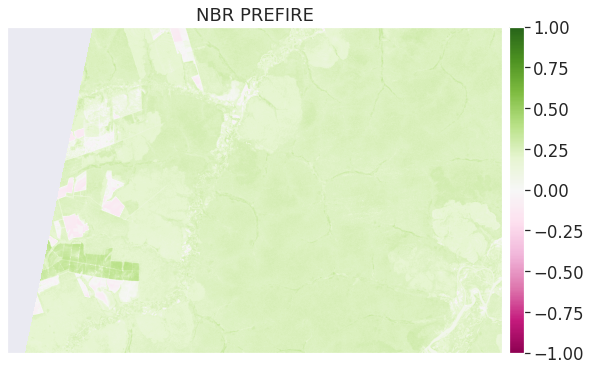

In [25]:
# Calculate NBR & plot PREFIRE
landsat_prefire_nbr = (
    landsat_pre_fire[3]-landsat_pre_fire[4]) / (landsat_pre_fire[3]+landsat_pre_fire[4])

fig, ax = plt.subplots(figsize=(12, 6))

ep.plot_bands(landsat_prefire_nbr,
              cmap='PiYG',
              vmin=-1,
              vmax=1,
              ax=ax,
              extent=extent_landsat,
              title="NBR PREFIRE")

plt.show()

## dNBR

In [26]:
# Calculate dnbr
dnbr_landsat = landsat_prefire_nbr - landsat_postfire_nbr
dnbr_landsat

<xarray.DataArray (y: 1478, x: 2243)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ..., -0.0479207 ,
        -0.04090217, -0.03930303],
       [        nan,         nan,         nan, ..., -0.05739114,
        -0.04938589, -0.03964801],
       [        nan,         nan,         nan, ..., -0.03002572,
        -0.03566407, -0.02861936]], dtype=float32)
Coordinates:
  * x            (x) float64 1.648e+05 1.648e+05 ... 2.32e+05 2.320e+05
  * y            (y) float64 -1.237e+06 -1.237e+06 ... -1.281e+06 -1.281e+06
    spatial_ref  int64 0

Finally you can classify the data. Remember that dNBR has a set of classification bins and associated categories that are commonly used. When you have calculated NBR - classify the output raster using the np.digitize() function. Use the dNBR classes below.

In [27]:
# Define dNBR classification bins
dnbr_class_bins = [-np.inf, -.1, .1, .27, .66, np.inf]

#dnbr_landsat_class = np.digitize(dnbr_landsat, dnbr_class_bins)

dnbr_landsat_class = xr.apply_ufunc(np.digitize,
                                    dnbr_landsat,
                                    dnbr_class_bins)
dnbr_landsat_class

<xarray.DataArray (y: 1478, x: 2243)>
array([[6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       ...,
       [6, 6, 6, ..., 2, 2, 2],
       [6, 6, 6, ..., 2, 2, 2],
       [6, 6, 6, ..., 2, 2, 2]])
Coordinates:
  * x            (x) float64 1.648e+05 1.648e+05 ... 2.32e+05 2.320e+05
  * y            (y) float64 -1.237e+06 -1.237e+06 ... -1.281e+06 -1.281e+06
    spatial_ref  int64 0

In [28]:
dnbr_cat_names = ["Enhanced Regrowth",
                  "Unburned",
                  "Low Severity",
                  "Moderate Severity",
                  "High Severity"]

nbr_colors = ["g",
              "yellowgreen",
              "peachpuff",
              "coral",
              "maroon"]
nbr_cmap = ListedColormap(nbr_colors)

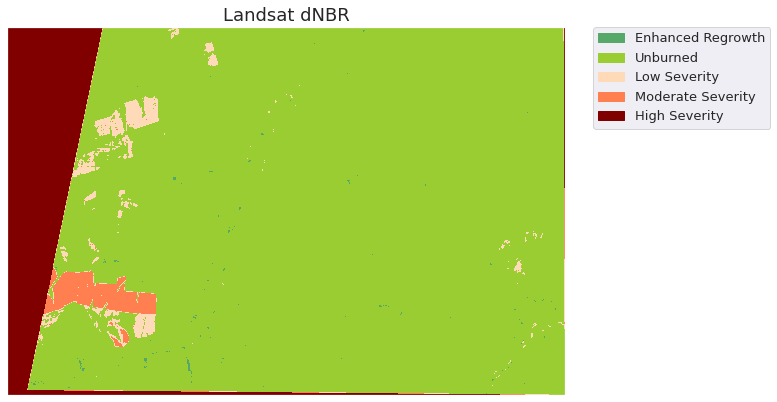

In [31]:
# Plot the data with a custom legend
dnbr_landsat_class_plot = ma.masked_array(
    dnbr_landsat_class.values, dnbr_landsat_class.isnull())

fig, ax = plt.subplots(figsize=(10, 8))


classes = np.unique(dnbr_landsat_class_plot)
classes = classes.tolist()[:5]

ep.plot_bands(dnbr_landsat_class_plot,
              cmap=nbr_cmap,
              vmin=1,
              vmax=5,
              title="Landsat dNBR",
              cbar=False,
              scale=False,
              extent=extent_landsat,
              ax=ax)

ep.draw_legend(im_ax=ax.get_images()[0],
               classes=classes,
               titles=dnbr_cat_names)

plt.show()

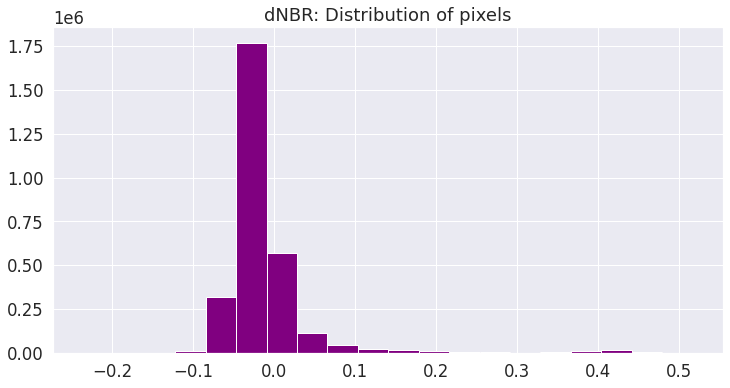

In [33]:
ep.hist(dnbr_landsat.values,
        figsize=(12, 6),
        title=["dNBR: Distribution of pixels"])

plt.show()

In [34]:
!mkdir -p $folder_path/CHECK/

In [36]:
landsat_postfire_nbr_outpath = os.path.join(folder_path+"/CHECK/check_dNBR.tif")

# Writing the ndvi raster object
landsat_postfire_nbr.rio.to_raster(landsat_postfire_nbr_outpath)